In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import _pickle as pickle

import numpy as np

from astropy.table import Table, Column

import matplotlib as mpl
import matplotlib.pyplot as plt

from asap import io
from asap import smf 
from asap import config
from asap import fitting

plt.rc('text', usetex=True)

## Halo mass predictions for nearby massive clusters

### DeMaio, Gonzalez, Zabludoff, Zaritsky et al. (2018) Results for CLASH clusters

* The colour gradients of the BCG+ICL become bluer with increasing radius out to 53–100 kpc for all but one system.
* The BCG+ICL luminosities and stellar masses are too large for the ICL stars to come from the dissolution of dwarf galaxies alone, given the observed evolution of the faint end of the cluster galaxy luminosity function, implying instead that the ICL grows from the stripping of more massive galaxies.
* We find that the ICL at 100 kpc has a colour similar to a $10^{10.0} M_{\odot}$ galaxy and that 75 per cent of the total BCG+ICL luminosity at r < 100 kpc is consistent with originating in galaxies with $L > 0.2 \times L^{\star}$ ($\log M_{\star} >10.4$), assuming conservatively that these galaxies are completely disrupted.

In [4]:
demaio18 = Table() 
demaio18.add_column(Column(
    data=np.asarray(['A611', 'MS2137', 'X0220', 'R1532', 'R2248',
                     'M1931', 'M1115', 'S1120', 'X0111', 'S1120_2',
                     'S1120_1', 'S1120_3', 'R1334', 'M1720', 'M0429',
                     'M0416', 'M1206', 'M0329', 'R1347', 'M1311', 
                     'M1149', 'M2129', 'CL1226']), 
    name='name'))

m1149_idx = 20
m1149_m100 = 12.7E11
m1149_m10 = 1.9E11

# Ebeling et al. 2014
m1149_m500c = 7.0E14

# Golovich+2016
m1149_m200c = 16.7E14

In [5]:
demaio18.add_column(Column(
    data=np.asarray([13.44E14, 10.78E14, np.nan, 7.01E14, 19.81E14,
                     11.62E14, 17.91E14, np.nan, np.nan, np.nan,
                     np.nan, np.nan, np.nan, 11.18E14, 8.88E14, 
                     11.43E14, 15.05E14, 12.70E14, 35.40E14, np.nan,
                     28.86E14, 7.78E14, np.nan]),
    name='m200_u18'))

demaio18.add_column(Column(
    data=np.asarray([3.39E14, 3.17E14, np.nan, 1.49E14, 5.97E14,
                     2.84E14, 3.81E14, np.nan, np.nan, np.nan,
                     np.nan, np.nan, np.nan, 2.38E14, 1.70E14, 
                     2.66E14, 4.6E14, 2.19E14, 5.05E14, np.nan, 
                     5.92E14, 2.43E14, np.nan]),
    name='m200_err_u18'))

In [6]:
demaio18.add_column(Column(
    data=np.asarray([0.288, 0.313, 0.330, 0.345, 0.348,
                     0.352, 0.352, 0.369, 0.370, 0.370,
                     0.371, 0.371, 0.384, 0.391, 0.399,
                     0.420, 0.440, 0.450, 0.451, 0.494,
                     0.544, 0.570, 0.890]),
    name='z'))

demaio18.add_column(Column(
    data=np.asarray([3.66E14, 2.31E14, 0.65E14, 2.04E14, 7.06E14,
                     2.75E14, 3.60E14, 0.80E14, 0.60E14, 0.33E14,
                     0.49E14, 0.36E14, 0.33E14, 2.63E14, 2.26E14,
                     3.14E14, 5.43E14, 3.41E14, 9.38E14, 2.09E14,
                     3.67E14, 3.81E14, 6.08E14]),
    name='m500'))

demaio18.add_column(Column(
    data=np.asarray([0.25E14, 0.18E14, 0.27E14, 0.23E14, 0.52E14,
                     0.25E14, 0.28E14, 0.49E14, 0.22E14, 0.15E14,
                     0.24E14, 0.37E14, 0.39E14, 0.24E14, 0.25E14, 
                     0.51E14, 0.46E14, 0.33E14, 0.56E14, 0.22E14,
                     0.58E14, 0.78E14, 1.89E14]),
    name='m500_err'))

In [7]:
demaio18.add_column(Column(
    data=np.asarray([3.42E11, 3.62E11, 2.23E11, 3.12E11, 4.41E11,
                     3.23E11, 2.02E11, 2.55E11, 2.56E11, 2.42E11,
                     1.31E11, 2.79E11, 1.54E11, 3.52E11, 3.53E11,
                     3.35E11, 2.79E11, 3.55E11, 2.90E11, 3.05E11,
                     1.90E11, 2.11E11, 4.87E11]),
    name='m10'))

demaio18.add_column(Column(
    data=np.asarray([0.01E11, 0.01E11, 0.01E11, 0.02E11, 0.01E11,
                     0.01E11, 0.01E11, 0.01E11, 0.01E11, 0.01E11,
                     0.01E11, 0.01E11, 0.01E11, 0.01E11, 0.01E11,
                     0.01E11, 0.01E11, 0.01E11, 0.01E11, 0.01E11,
                     0.01E11, 0.02E11, 0.02E11]),
    name='m10_err'))

demaio18.add_column(Column(
    data=np.asarray([12.8E11, 9.14E11, 5.48E11, 8.88E11, 18.4E11,
                     10.5E11, 9.64E11, 6.85E11, 6.81E11, 5.82E11,
                     3.75E11, 6.45E11, 3.52E11, 11.4E11, 15.1E11,
                     11.8E11, 10.8E11, 13.2E11, 12.0E11, 8.69E11,
                     12.7E11, 7.17E11, 19.5E11]),
    name='m100'))

demaio18.add_column(Column(
    data=np.asarray([0.40E11, 0.23E11, 0.16E11, 0.28E11, 0.49E11,
                     1.00E11, 0.71E11, 0.17E11, 0.19E11, 0.25E11,
                     0.19E11, 0.16E11, 0.15E11, 0.66E11, 0.48E11,
                     0.45E11, 0.95E11, 0.93E11, 1.10E11, 0.20E11,
                     1.38E11, 0.37E11, 0.50E11]),
    name='m100_err'))

In [8]:
from colossus.cosmology import cosmology
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration

my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.30, 'Ob0': 0.043, 'sigma8': 0.8, 'ns': 0.97}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

mvir = 1E14
redshift = 0.4

cvir = concentration.concentration(mvir, 'vir', redshift, model='diemer18')

m200c, r200c, c200c = mass_defs.changeMassDefinition(mvir, cvir, redshift, 'vir', '200c')
m500c, r500c, c500c = mass_defs.changeMassDefinition(mvir, cvir, redshift, 'vir', '500c')

print(mvir / m200c)
print(m500c / m200c)

1.152997691986118
0.6918248482651047


### S16A massive galaxy catalog

In [9]:
test_dir = '../model'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

hsc_mass = Table.read(
    os.path.join(cfg['obs']['dir'], 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

print("# There are %d HSC galaxies" % len(hsc_mass))

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

### Distribution over the aperture mass plane

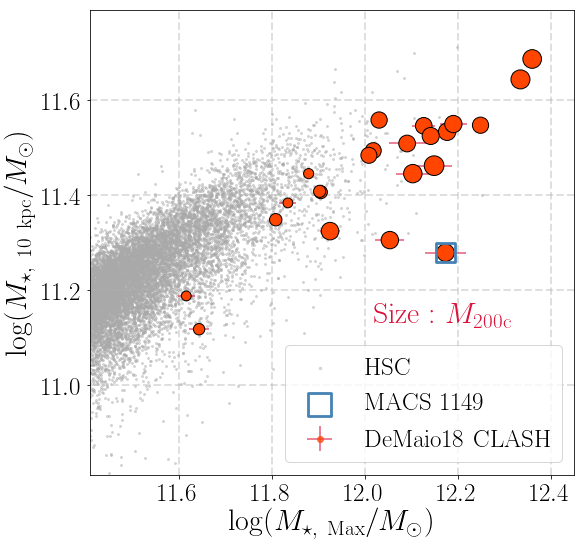

In [9]:
fig_1 = plt.figure(figsize=(8, 7.5))
fig_1.subplots_adjust(left=0.15, right=0.99, bottom=0.13, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

ax1.scatter(hsc_mass['logm_max'], hsc_mass['logm_10'],
            s=4, c='darkgray', alpha=0.4, label=r'$\mathrm{HSC}$')

x_err = np.log10(demaio18['m100'] + demaio18['m100_err']) - np.log10(demaio18['m100'])
y_err = np.log10(demaio18['m10'] + demaio18['m10_err']) - np.log10(demaio18['m10'])

ax1.errorbar(np.log10(demaio18['m100']) + 0.07, np.log10(demaio18['m10']), 
             xerr=x_err, yerr=y_err, 
             fmt='o', color='orangered', ecolor='crimson',
             alpha=0.7, marker='o', markersize=5,
             label=r'$\mathrm{DeMaio18\ CLASH}$', zorder=2)

ax1.scatter(np.log10(demaio18['m100']) + 0.07, 
            np.log10(demaio18['m10']),
            marker='o', facecolor='orangered', edgecolor='k',
            s=(np.log10(demaio18['m500'] / 0.692) - 13.2) * 200.0,
            label='__no_label__', zorder=4)

ax1.scatter(np.log10(demaio18['m100'][m1149_idx]) + 0.07, 
            np.log10(demaio18['m10'][m1149_idx]),
            marker='s', facecolor='none', edgecolor='steelblue',
            s=380.0, linewidth=2.8,
            label=r'$\mathrm{MACS\ 1149}$', zorder=5)


legend = ax1.legend(loc='lower right', fontsize=25, markerscale=1.2)

ax1.text(12.02, 11.12, r'$\mathrm{Size:\ }M_{\rm 200c}$', color='crimson', fontsize=30)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlim(11.41, 12.45)
ax1.set_ylim(10.81, 11.79)

_ = ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log (M_{\star,\ \mathrm{10\ kpc}}/M_{\odot})$', fontsize=30)

### Comparison of the predicted halo mass

In [10]:
# Best fit scaling relations
def assign_mvir_plane(logm_max, logm_10, a_plane=3.257, a_pivot=11.72, 
                      b_plane=-2.456, b_pivot=11.34, c_plane=13.6901):
    """Assign Mvir to galaxies with observed aperture masses."""
    return a_plane * (logm_max - a_pivot) + b_plane * (logm_10 - b_pivot) + c_plane

# Random forest model
from sklearn.externals import joblib
mstar_forest = joblib.load('../model/um_asap_default_mvir_random_forest.pkl') 

# Symbolic regression model
import _pickle as pickle
with open('../model/um_asap_default_mvir_symbolic_regression.pkl', 'rb') as f:
    est_gp = pickle.load(f)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
# Isolate out MACS1149
m1149 = demaio18[(demaio18['m100'] > 1E12) & (demaio18['m10'] <= 2.5E11)]
m1149_mask = (demaio18['m100'] > 1E12) & (demaio18['m10'] <= 2.5E11)

# Convert the 100 kpc mass into maximum 1-D mass 
demaio_mass = np.stack((np.array(np.log10(demaio18['m10'])),
                        np.array(np.log10(demaio18['m100']) + 0.09)), axis=-1)

# Random forest predictions
demaio_forest = mstar_forest.predict(demaio_mass)

# Symbolic regression predictions
demaio_symbol = est_gp.predict(demaio_mass)

# 2-D scaling relation predictions
demaio_plane = assign_mvir_plane(np.log10(demaio18['m100']) + 0.09, np.log10(demaio18['m10']))

# Simple SHMR predictions|
demaio_simple = 2.361 * (np.log10(demaio18['m100'] + 0.09) - 11.59) + 13.437

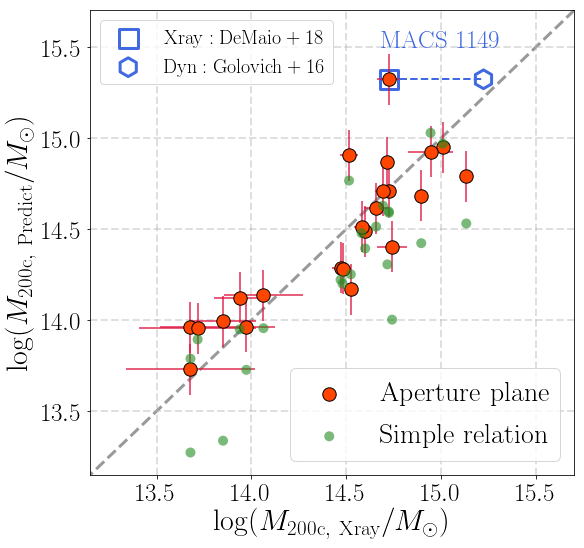

In [14]:
fig_2 = plt.figure(figsize=(8, 7.5))
fig_2.subplots_adjust(left=0.15, right=0.99, bottom=0.13, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

x_err = np.log10(demaio18['m500'] + demaio18['m500_err']) - np.log10(demaio18['m500'])

# One-to-one relation
m200_arr = np.linspace(13.0, 15.8, 100)
ax1.plot(m200_arr, m200_arr, linestyle='--', linewidth=3.0, c='gray', alpha=0.8, zorder=0)

# Convert M500 into M200c
ax1.errorbar(np.log10(demaio18['m500'] / 0.692), demaio_plane - np.log10(1.153),
             yerr=np.full(len(demaio_plane), 0.14), xerr=x_err, 
             fmt='o', color='orangered', ecolor='crimson',
             alpha=0.9, marker='o', markersize=10,
             label='__no_label__', zorder=2)

ax1.scatter(np.log10(demaio18['m500'] / 0.692), demaio_plane - np.log10(1.153), 
            s=180, facecolor='orangered', edgecolor='k',
            label=r'$\mathrm{Aperture\ plane}$', zorder=3)

ax1.scatter(np.log10(demaio18['m500'] / 0.692), demaio_simple - np.log10(1.153),
            s=100, alpha=0.6,
            facecolor='forestgreen', edgecolor='none',
            label=r'$\mathrm{Simple\ relation}$', zorder=3)

legend1 = ax1.legend(loc='lower right', fontsize=28)
ax2 = plt.gca().add_artist(legend1)


# MACS1149
macs1 = ax1.scatter(np.log10(m1149['m500'] / 0.692), demaio_plane[m1149_mask] - np.log10(1.153),
                    s=350, facecolor='none', edgecolor='royalblue', marker='s',
                    linewidth=3.0, label=r'$\mathrm{Xray: DeMaio+18}$')

macs2 = ax1.scatter(np.log10(m1149_m200c), demaio_plane[m1149_mask] - np.log10(1.153),
                    s=350, facecolor='none', edgecolor='royalblue', marker='h',
                    linewidth=3.0, label=r'$\mathrm{Dyn: Golovich+16}$')

ax1.plot([np.log10(m1149['m500'] / 0.692), np.log10(m1149_m200c)],
         [demaio_plane[m1149_mask] - np.log10(1.153), demaio_plane[m1149_mask] - np.log10(1.153)],
         linestyle='--', linewidth=2.0, color='royalblue', 
         label='__no_label__')

ax1.legend(handles=[macs1, macs2], loc='upper left', fontsize=20)
ax1.text(14.68, 15.49, r'$\mathrm{MACS\ 1149}$', color='royalblue', fontsize=25)
        
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlim(13.15, 15.7)
ax1.set_ylim(13.15, 15.7)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{200c,\ Xray}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log (M_{\mathrm{200c,\ Predict}}/M_{\odot})$', fontsize=30)

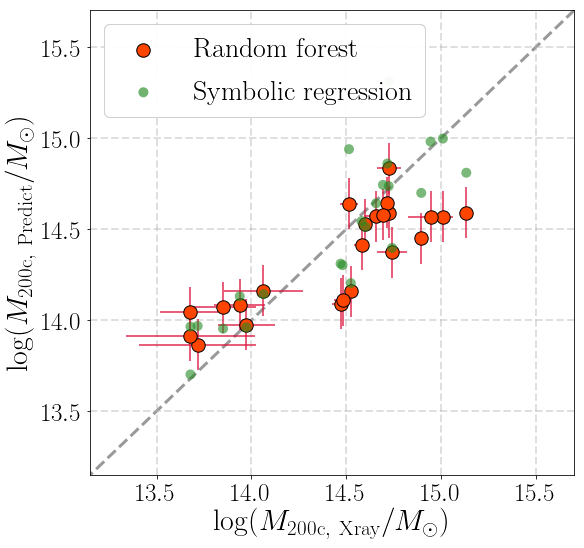

In [15]:
fig_3 = plt.figure(figsize=(8, 7.5))
fig_3.subplots_adjust(left=0.15, right=0.99, bottom=0.13, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

x_err = np.log10(demaio18['m500'] + demaio18['m500_err']) - np.log10(demaio18['m500'])

# One-to-one relation
m200_arr = np.linspace(13.0, 15.8, 100)
ax1.plot(m200_arr, m200_arr, linestyle='--', linewidth=3.0, c='gray', alpha=0.8, zorder=0)

# Convert M500 into M200c
ax1.errorbar(np.log10(demaio18['m500'] / 0.692), demaio_forest - np.log10(1.153),
             yerr=np.full(len(demaio_forest), 0.14), xerr=x_err, 
             fmt='o', color='orangered', ecolor='crimson',
             alpha=0.9, marker='o', markersize=10,
             label='__no_label__', zorder=2)

ax1.scatter(np.log10(demaio18['m500'] / 0.692), demaio_forest - np.log10(1.153), s=180, 
            facecolor='orangered', edgecolor='k',
            label=r'$\mathrm{Random\ forest}$', zorder=3)

ax1.scatter(np.log10(demaio18['m500'] / 0.692), demaio_symbol - np.log10(1.153),
            s=100, alpha=0.6,
            facecolor='forestgreen', edgecolor='none',
            label=r'$\mathrm{Symbolic\ regression}$', zorder=3)

legend1 = ax1.legend(loc='upper left', fontsize=28)
ax2 = plt.gca().add_artist(legend1)
        
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlim(13.15, 15.7)
ax1.set_ylim(13.15, 15.7)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{200c,\ Xray}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log (M_{\mathrm{200c,\ Predict}}/M_{\odot})$', fontsize=30)

### Comparison with the WL measurements from Umetsu+18

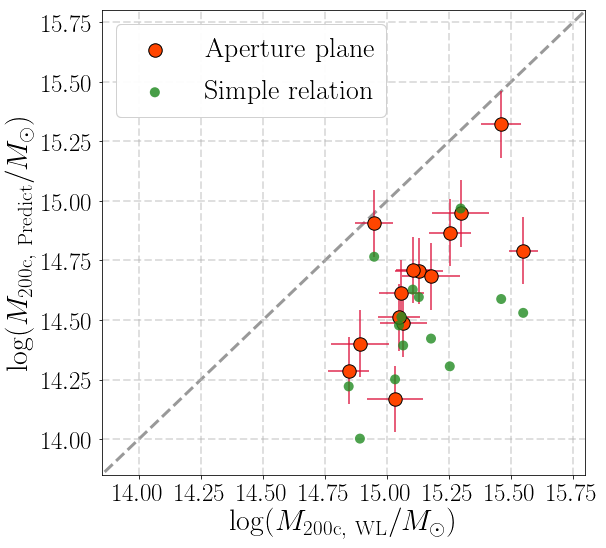

In [16]:
fig_4 = plt.figure(figsize=(8, 7.5))
fig_4.subplots_adjust(left=0.15, right=0.99, bottom=0.13, top=0.99, wspace=0.00, hspace=0.00)
ax1 = fig_4.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

x_err = np.log10(demaio18['m200_err_u18'] + demaio18['m200_u18']) - np.log10(demaio18['m200_u18'])

m200_arr = np.linspace(13.0, 15.8, 100)
ax1.plot(m200_arr, m200_arr, linestyle='--', linewidth=3.0, c='gray', alpha=0.8, zorder=0)

ax1.errorbar(np.log10(demaio18['m200_u18']), demaio_plane - np.log10(1.153),
             yerr=np.full(len(demaio_plane), 0.14), xerr=x_err, 
             fmt='o', color='orangered', ecolor='crimson',
             alpha=0.9, marker='o', markersize=10,
             label='__no_label__', zorder=2)

ax1.scatter(np.log10(demaio18['m200_u18']), demaio_plane - np.log10(1.153),
            s=180, 
            facecolor='orangered', edgecolor='k',
            label=r'$\mathrm{Aperture\ plane}$', zorder=3)

ax1.scatter(np.log10(demaio18['m200_u18']), demaio_simple - np.log10(1.153),
            s=100, alpha=0.8,
            facecolor='forestgreen', edgecolor='none',
            label=r'$\mathrm{Simple\ relation}$', zorder=3)

legend1 = ax1.legend(loc='upper left', fontsize=28)
ax2 = plt.gca().add_artist(legend1)
        
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlim(13.85, 15.8)
ax1.set_ylim(13.85, 15.8)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{200c,\ WL}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\log (M_{\mathrm{200c,\ Predict}}/M_{\odot})$', fontsize=30)

### Save the figures

In [17]:
fig_1.savefig('fig/fig11_a.pdf', dpi=120)

fig_2.savefig('fig/fig11_b.pdf', dpi=120)

### Make a new figure for proposal

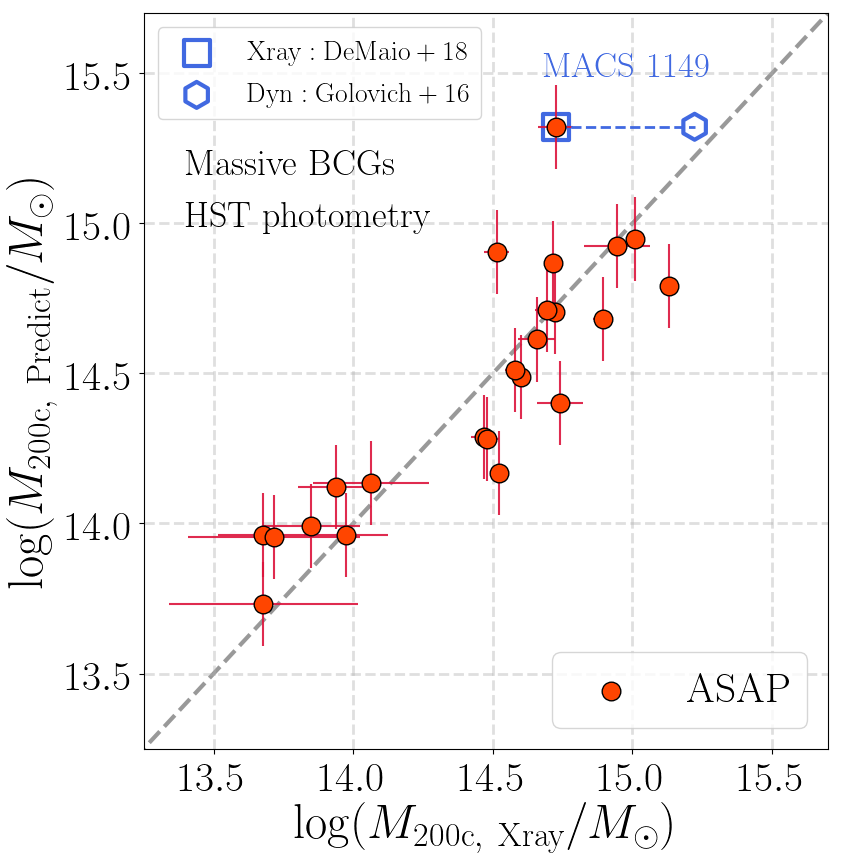

In [18]:
fig_2 = plt.figure(figsize=(8.0, 8.5))
fig_2.subplots_adjust(left=0.14, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

x_err = np.log10(demaio18['m500'] + demaio18['m500_err']) - np.log10(demaio18['m500'])

# One-to-one relation
m200_arr = np.linspace(13.0, 15.8, 100)
ax1.plot(m200_arr, m200_arr, linestyle='--', linewidth=3.0, c='gray', alpha=0.8, zorder=0)

# Convert M500 into M200c
ax1.errorbar(np.log10(demaio18['m500'] / 0.692), demaio_plane - np.log10(1.153),
             yerr=np.full(len(demaio_plane), 0.14), xerr=x_err, 
             fmt='o', color='orangered', ecolor='crimson',
             alpha=0.9, marker='o', markersize=10,
             label='__no_label__', zorder=2)

ax1.scatter(np.log10(demaio18['m500'] / 0.692), demaio_plane - np.log10(1.153), 
            s=180, facecolor='orangered', edgecolor='k',
            label=r'$\mathrm{ASAP}$', zorder=3)

legend1 = ax1.legend(loc='lower right', fontsize=30)
ax2 = plt.gca().add_artist(legend1)

# MACS1149
macs1 = ax1.scatter(np.log10(m1149['m500'] / 0.692), demaio_plane[m1149_mask] - np.log10(1.153),
                    s=350, facecolor='none', edgecolor='royalblue', marker='s',
                    linewidth=3.0, label=r'$\mathrm{Xray: DeMaio+18}$')

macs2 = ax1.scatter(np.log10(m1149_m200c), demaio_plane[m1149_mask] - np.log10(1.153),
                    s=350, facecolor='none', edgecolor='royalblue', marker='h',
                    linewidth=3.0, label=r'$\mathrm{Dyn: Golovich+16}$')

ax1.plot([np.log10(m1149['m500'] / 0.692), np.log10(m1149_m200c)],
         [demaio_plane[m1149_mask] - np.log10(1.153), demaio_plane[m1149_mask] - np.log10(1.153)],
         linestyle='--', linewidth=2.0, color='royalblue', 
         label='__no_label__')

ax1.legend(handles=[macs1, macs2], loc='upper left', fontsize=20)
ax1.text(14.68, 15.49, r'$\mathrm{MACS\ 1149}$', color='royalblue', fontsize=25)
        
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.set_xlim(13.25, 15.7)
ax1.set_ylim(13.25, 15.7)

_ = ax1.text(0.06, 0.78, r'$\mathrm{Massive\ BCGs}$', 
             transform=ax1.transAxes, fontsize=26)

_ = ax1.text(0.06, 0.71, r'$\mathrm{HST\ photometry}$', 
             transform=ax1.transAxes, fontsize=26)

#_ = ax1.text(0.06, 0.64, r'$\mathrm{Circular\ aperture}$', 
#             transform=ax1.transAxes, fontsize=26)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{200c,\ Xray}}/M_{\odot})$', fontsize=35)
_ = ax1.set_ylabel(r'$\log (M_{\mathrm{200c,\ Predict}}/M_{\odot})$', fontsize=35)